<a href="https://colab.research.google.com/github/namigabbasov/ai-literacy-bibliometric-analysis/blob/main/scripts/python_ai_lit_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **RQ1 – Knowledge Dissemination: Where is AI Literacy Research Published?**

## Setup: Install and Import Required Libraries

In [123]:
#!pip install -q pandas numpy matplotlib seaborn plotly networkx openpyxl tqdm nltk spacy scikit-learn wordcloud


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx

import nltk
import re
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

#nltk.download('stopwords')
#nltk.download('punkt')

### Display settings
pd.set_option('display.max_columns', 50)
sns.set_theme(style="whitegrid", palette="deep")

## Load AI Literacy Dataset from GitHub

In [124]:
url = "https://raw.githubusercontent.com/namigabbasov/ai-literacy-bibliometric-analysis/refs/heads/main/data/ai_literacy.csv"
df = pd.read_csv(url, low_memory=False)

In [125]:
list(df.columns)

['Authors',
 'Author full names',
 'Author(s) ID',
 'Title',
 'Year',
 'Source title',
 'Volume',
 'Issue',
 'Art. No.',
 'Page start',
 'Page end',
 'Page count',
 'Cited by',
 'DOI',
 'Link',
 'Affiliations',
 'Authors with affiliations',
 'Abstract',
 'Author Keywords',
 'Index Keywords',
 'Molecular Sequence Numbers',
 'Chemicals/CAS',
 'Tradenames',
 'Manufacturers',
 'Funding Details',
 'Funding Texts',
 'References',
 'Correspondence Address',
 'Editors',
 'Publisher',
 'Sponsors',
 'Conference name',
 'Conference date',
 'Conference location',
 'Conference code',
 'ISSN',
 'ISBN',
 'CODEN',
 'PubMed ID',
 'Language of Original Document',
 'Abbreviated Source Title',
 'Document Type',
 'Publication Stage',
 'Open Access',
 'Source',
 'EID']

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Authors                        2176 non-null   object
 1   Author full names              2176 non-null   object
 2   Author(s) ID                   2176 non-null   object
 3   Title                          2224 non-null   object
 4   Year                           2224 non-null   object
 5   Source title                   1758 non-null   object
 6   Volume                         1504 non-null   object
 7   Issue                          899 non-null    object
 8   Art. No.                       658 non-null    object
 9   Page start                     1227 non-null   object
 10  Page end                       1215 non-null   object
 11  Page count                     2224 non-null   object
 12  Cited by                       2224 non-null   object
 13  DOI

In [127]:
### Keep essential columns for analysis
keep_cols = [
    'Authors', 'Title', 'Year', 'Source title', 'Author Keywords', 'Index Keywords',
    'Abstract', 'Cited by', 'Affiliations', 'DOI', 'Document Type', 'Conference name',
    'Publisher', 'Language of Original Document', 'Open Access', 'EID'
]
df = df[keep_cols].copy()

### Drop duplicates and missing titles/years
df.drop_duplicates(subset='Title', keep='first', inplace=True)
df = df[df['Title'].notna() & df['Year'].notna()].copy()

### Convert year to integer
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

### Clean up 'Document Type' column
df['Document Type'] = df['Document Type'].astype(str).str.strip()

### Remove rows with missing or blank Document Type
df = df[df['Document Type'].notna() & (df['Document Type'] != '')].copy()

### Drop unwanted document types (including corrupted one)
drop_types = [
    'Erratum', 'Letter', 'Data paper',
    'Retracted', 'Short survey'
]

mask = df['Document Type'].isin(drop_types) | df['Document Type'].str.contains(
    'Godspeed scale|anthropomorphism', case=False, na=False
)

before = len(df)
df_clean = df[~mask].copy()
after = len(df_clean)

### Summary
print("Clean dataset created.")
print(f"Records before cleaning: {before:,}")
print(f"Records after cleaning:  {after:,}")
print(f"Records dropped:        {before - after:,}")
print(f"Year range: {df_clean['Year'].min()}–{df_clean['Year'].max()}")
print("\nUnique document types retained:")
print(df_clean['Document Type'].value_counts())


Clean dataset created.
Records before cleaning: 2,210
Records after cleaning:  2,198
Records dropped:        12
Year range: 2016–2025

Unique document types retained:
Document Type
Article              1177
Conference paper      593
Book chapter          199
Review                122
Note                   39
Conference review      32
Editorial              23
Book                   12
nan                     1
Name: count, dtype: int64


In [128]:
### Keep essential columns for analysis
keep_cols = [
    'Authors', 'Title', 'Year', 'Source title', 'Author Keywords', 'Index Keywords',
    'Abstract', 'Cited by', 'Affiliations', 'DOI', 'Document Type', 'Conference name',
    'Publisher', 'Language of Original Document', 'Open Access', 'EID'
]
df = df[keep_cols].copy()

### Drop duplicates and missing titles/years
df.drop_duplicates(subset='Title', keep='first', inplace=True)
df = df[df['Title'].notna() & df['Year'].notna()].copy()

### Convert year to integer
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

### Clean up 'Document Type' column a bit
df['Document Type'] = df['Document Type'].astype(str).str.strip()

### Drop unwanted document types (including corrupted one)
drop_types = [
    'Erratum', 'Letter', 'Data paper',
    'Retracted', 'Short survey'
]

mask = df['Document Type'].isin(drop_types) | df['Document Type'].str.contains(
    'Godspeed scale|anthropomorphism', case=False, na=False
)

before = len(df)
df_clean = df[~mask].copy()
after = len(df_clean)

### Summary
print("Clean dataset created.")
print(f"Records before cleaning: {before:,}")
print(f"Records after cleaning:  {after:,}")
print(f"Records dropped:        {before - after:,}")
print(f"Year range: {df_clean['Year'].min()}–{df_clean['Year'].max()}")
print("\nUnique document types retained:")
print(df_clean['Document Type'].value_counts())


Clean dataset created.
Records before cleaning: 2,209
Records after cleaning:  2,198
Records dropped:        11
Year range: 2016–2025

Unique document types retained:
Document Type
Article              1177
Conference paper      593
Book chapter          199
Review                122
Note                   39
Conference review      32
Editorial              23
Book                   12
nan                     1
Name: count, dtype: int64


## Descriptive Bibliometrics

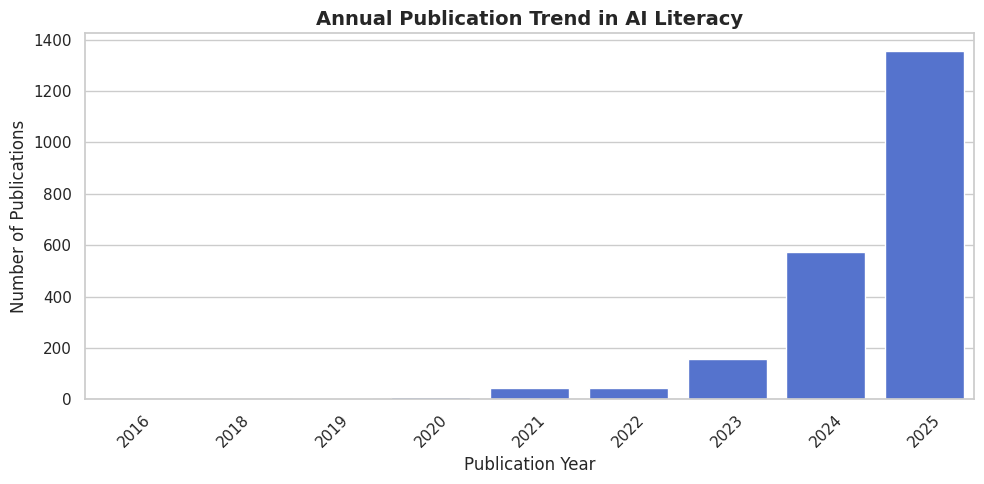

In [129]:
### Annual publication trends
pubs_by_year = df_clean['Year'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=pubs_by_year.index, y=pubs_by_year.values, color='royalblue')
plt.title("Annual Publication Trend in AI Literacy", fontsize=14, weight='bold')
plt.xlabel("Publication Year")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

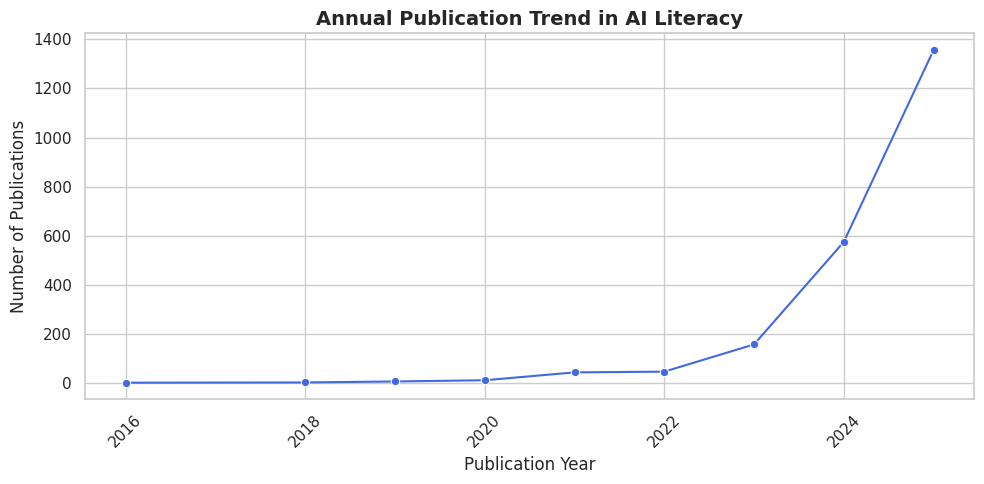

In [130]:
### Annual publication trends
pubs_by_year = df_clean['Year'].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.lineplot(x=pubs_by_year.index, y=pubs_by_year.values, marker='o', color='royalblue')
plt.title("Annual Publication Trend in AI Literacy", fontsize=14, weight='bold')
plt.xlabel("Publication Year")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


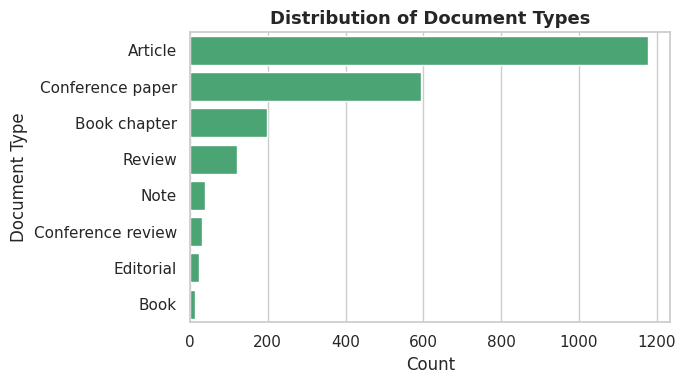

In [131]:
df_doc = df_clean.copy()
df_doc['Document Type'] = df_doc['Document Type'].astype(str).str.strip()

### Remove both real NaN and the literal string 'nan'
mask_valid = (
    df_doc['Document Type'].notna() &
    (df_doc['Document Type'].str.lower() != 'nan') &
    (df_doc['Document Type'] != '')
)
df_doc = df_doc[mask_valid]

### Count distribution
doc_types = df_doc['Document Type'].value_counts().sort_values(ascending=False)

### Plot
plt.figure(figsize=(7,4))
sns.barplot(y=doc_types.index, x=doc_types.values, color='mediumseagreen')
plt.title("Distribution of Document Types", fontsize=13, weight='bold')
plt.xlabel("Count")
plt.ylabel("Document Type")
plt.tight_layout()
plt.show()

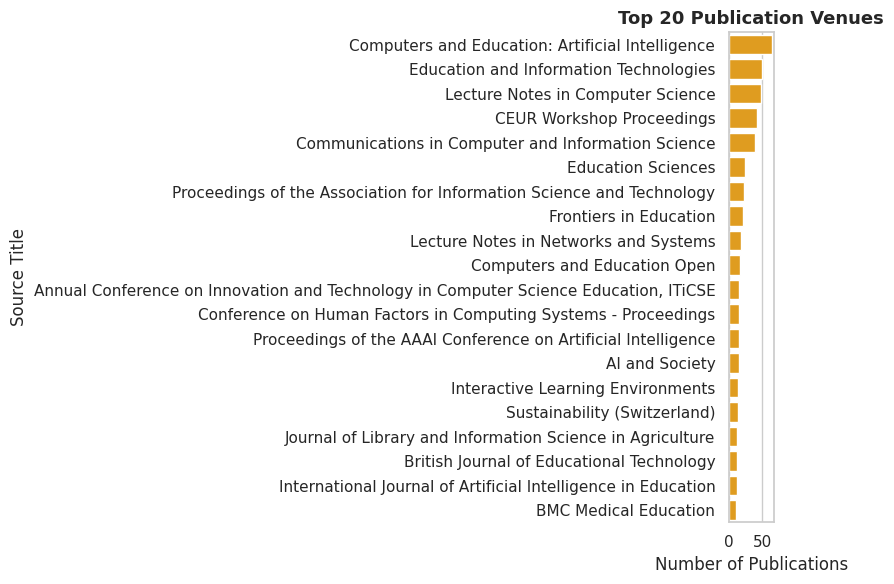

In [132]:
### top sources
top_sources = df_clean['Source title'].value_counts().head(20)
plt.figure(figsize=(8,6))
sns.barplot(y=top_sources.index, x=top_sources.values, color='orange')
plt.title("Top 20 Publication Venues", fontsize=13, weight='bold')
plt.xlabel("Number of Publications")
plt.ylabel("Source Title")
plt.tight_layout()
plt.show()

In [133]:
summary = {}

### Core dataset info
summary["Total Documents"] = len(df_clean)
summary["Timespan"] = f"{df_clean['Year'].min()}–{df_clean['Year'].max()}"

### Citations
if "Cited by" in df_clean.columns:
    df_clean["Cited by"] = pd.to_numeric(df_clean["Cited by"], errors="coerce")
    summary["Total Citations"] = int(df_clean["Cited by"].sum(skipna=True))
    summary["Average Citations per Document"] = round(df_clean["Cited by"].mean(skipna=True), 2)

### Annual growth rate
years = df_clean["Year"].dropna().astype(int)
yearly_counts = years.value_counts().sort_index()
if len(yearly_counts) > 1:
    growth_rate = ((yearly_counts.iloc[-1] / yearly_counts.iloc[0]) ** (1 / (len(yearly_counts) - 1)) - 1) * 100
    summary["Average Annual Growth Rate (%)"] = round(growth_rate, 2)

### Document types
doc_counts = df_clean["Document Type"].value_counts()
summary["Document Types"] = ", ".join([f"{k}: {v}" for k, v in doc_counts.items()])

### Open Access proportion
if "Open Access" in df_clean.columns:
    oa_rate = (df_clean["Open Access"].astype(str).str.lower() == "all").mean() * 100
    summary["Open Access (%)"] = round(oa_rate, 2)

### Author analysis
authors_series = df_clean["Authors"].dropna().str.split(";")
total_authorships = authors_series.apply(len).sum()
avg_authors_per_doc = total_authorships / len(authors_series)
summary["Average Authors per Document"] = round(avg_authors_per_doc, 2)

### Identify most prolific authors
from collections import Counter
authors_flat = [a.strip() for lst in authors_series for a in lst if a.strip()]
top_authors = Counter(authors_flat).most_common(10)
summary["Top Authors"] = ", ".join([f"{a} ({c})" for a, c in top_authors])

### Countries (extract from affiliations text)
if "Affiliations" in df_clean.columns:
    # Rough extraction: last comma segment tends to be country name
    affils = df_clean["Affiliations"].dropna().astype(str)
    countries = affils.str.extractall(r",\s*([A-Za-z\s]+)$")[0].str.strip()
    top_countries = countries.value_counts().head(10)
    summary["Top Countries"] = ", ".join([f"{c} ({n})" for c, n in top_countries.items()])

### Document age
summary["Average Document Age (years)"] = round(2025 - df_clean["Year"].mean(), 1)

### Build DataFrame
summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
display(summary_df)

,Metric,Value
0,Total Documents,2198
1,Timespan,2016–2025
2,Total Citations,28534
3,Average Citations per Document,12.98
4,Average Annual Growth Rate (%),146.36
5,Document Types,"Article: 1177, Conference paper: 593, Book cha..."
6,Open Access (%),0.0
7,Average Authors per Document,3.52
8,Top Authors,"Ng, D.T.K. (24), Breazeal, C. (20), Yang, Y. (..."
9,Top Countries,"United States (507), China (213), Hong Kong (1..."


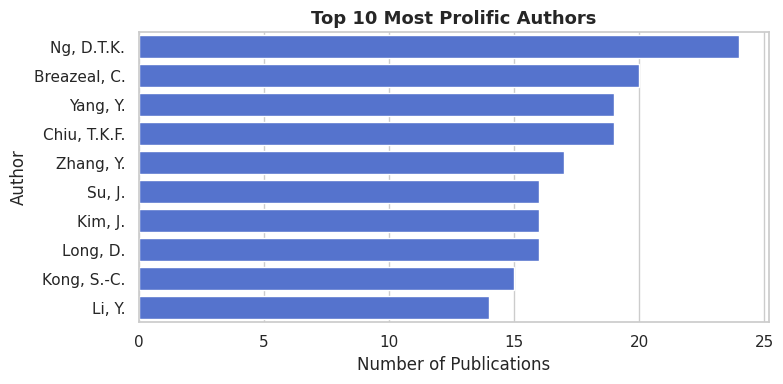

In [134]:
### top 10 authors plot
plt.figure(figsize=(8,4))
sns.barplot(
    y=[a for a, c in top_authors],
    x=[c for a, c in top_authors],
    color="royalblue"
)
plt.title("Top 10 Most Prolific Authors", fontsize=13, weight="bold")
plt.xlabel("Number of Publications")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

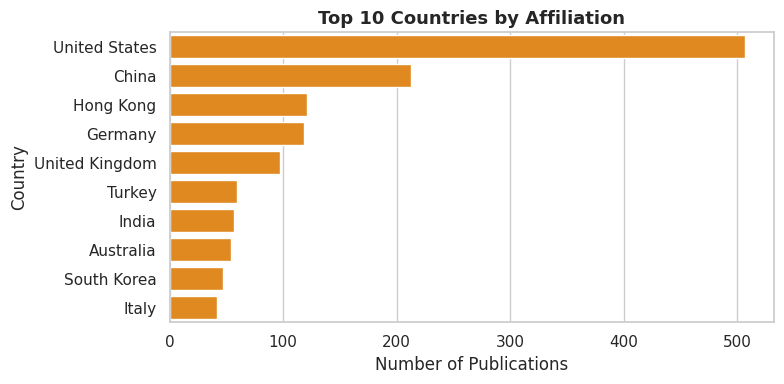

In [135]:
### Top 10 countries plot
if "Affiliations" in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.barplot(
        y=top_countries.index,
        x=top_countries.values,
        color="darkorange"
    )
    plt.title("Top 10 Countries by Affiliation", fontsize=13, weight="bold")
    plt.xlabel("Number of Publications")
    plt.ylabel("Country")
    plt.tight_layout()
    plt.show()

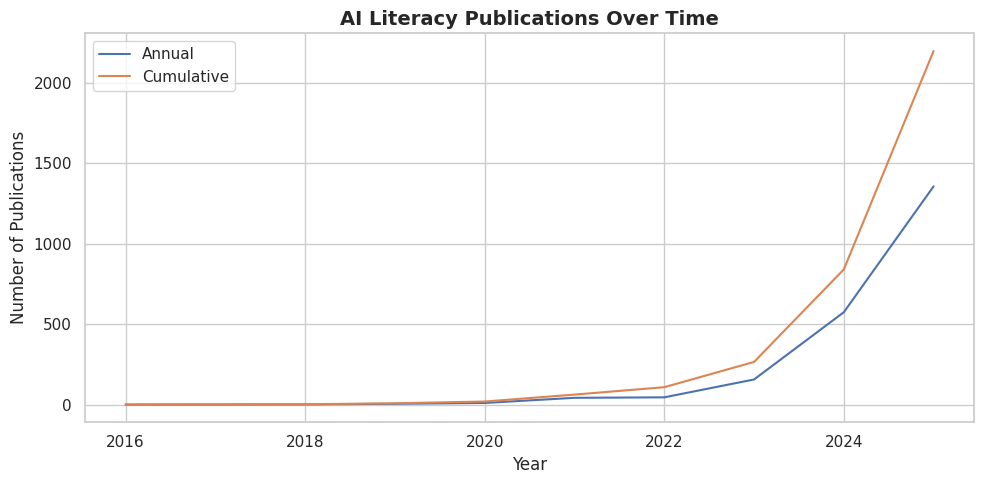

In [136]:
### Cumulative Publications and Smoothed Trend

yearly_counts = df_clean['Year'].value_counts().sort_index()
cumulative = yearly_counts.cumsum()

plt.figure(figsize=(10,5))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, label='Annual')
sns.lineplot(x=cumulative.index, y=cumulative.values, label='Cumulative')
plt.title("AI Literacy Publications Over Time", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.legend()
plt.tight_layout()
plt.show()


In [137]:
### top cited papers
top_cited = df_clean[['Title', 'Authors', 'Year', 'Source title', 'Cited by']].dropna().sort_values('Cited by', ascending=False).head(10)
display(top_cited)


,Title,Authors,Year,Source title,Cited by
2216,What is AI Literacy? Competencies and Design C...,"Long, D.; Magerko, B.",2020,Conference on Human Factors in Computing Syste...,1406
1973,Students’ voices on generative AI: perceptions...,"Chan, C.K.Y.; Hu, W.",2023,International Journal of Educational Technolog...,1045
2190,Conceptualizing AI literacy: An exploratory re...,"Ng, D.T.K.; Leung, J.K.L.; Chu, S.K.W.; Qiao, ...",2021,Computers and Education: Artificial Intelligence,970
2039,The role of ChatGPT in higher education: Benef...,"Rasul, T.; Nair, S.; Kalendra, D.; Robin, M.; ...",2023,Journal of Applied Learning and Teaching,418
1459,Embracing the future of Artificial Intelligenc...,"Walter, Y.",2024,International Journal of Educational Technolog...,394
2117,Measuring user competence in using artificial ...,"Wang, B.; Rau, P.-L.P.; Yuan, T.",2023,Behaviour and Information Technology,380
2110,Developing a model for AI Across the curriculu...,"Southworth, J.; Migliaccio, K.; Glover, J.; Gl...",2023,Computers and Education: Artificial Intelligence,354
2037,Teachers’ AI digital competencies and twenty-f...,"Ng, D.T.K.; Leung, J.K.L.; Su, J.; Ng, R.C.W.;...",2023,Educational Technology Research and Development,351
1974,AI literacy in K-12: a systematic literature r...,"Casal-Otero, L.; Catala, A.; Fernández-Morante...",2023,International Journal of STEM Education,348
2150,Artificial intelligence literacy in higher and...,"Laupichler, M.C.; Aster, A.; Schirch, J.; Raup...",2022,Computers and Education: Artificial Intelligence,327


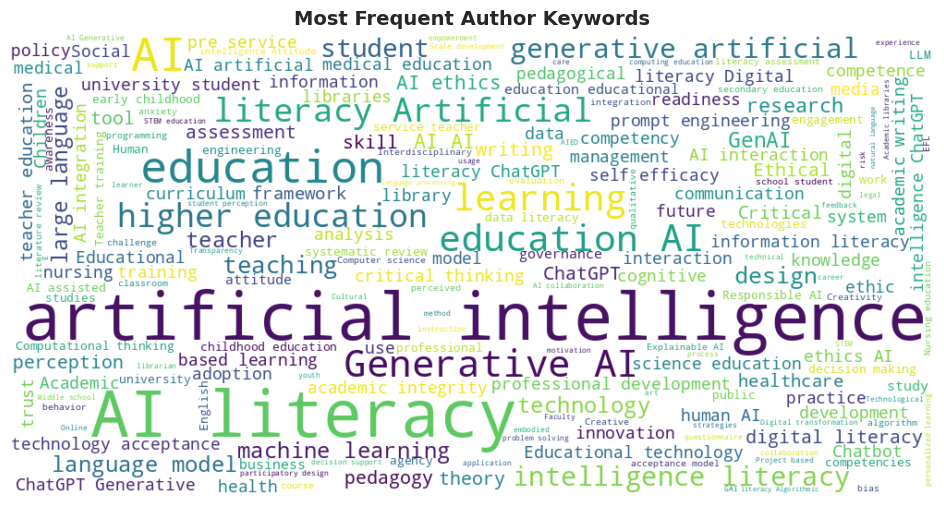

In [138]:
### Keyword Cloud & Frequency
text = " ".join(df_clean['Author Keywords'].dropna().astype(str))
wc = WordCloud(width=1000, height=500, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Author Keywords", fontsize=14, weight='bold')
plt.show()


##Country Productivity Map

In [142]:
### Extract country names from affiliations
affils = df_clean["Affiliations"].dropna().astype(str)
countries = affils.str.extractall(r",\s*([A-Za-z\s]+)$")[0].str.strip()
country_counts = countries.value_counts().reset_index()
country_counts.columns = ["Country", "Publications"]

### Plot interactive choropleth map
fig = px.choropleth(
    country_counts,
    locations="Country",
    locationmode="country names",
    color="Publications",
    hover_name="Country",
    color_continuous_scale="Viridis",
    title="AI Literacy Publications by Country (2016–2025)",
)
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type="natural earth")
)
fig.show()
